In [88]:
# logical change of basis
# example: in dual-rail 1Q gates are created by 2Q interactions

# |0>L = |01>, |1>L = |10>
# |e1> = |00>, |e2> = |11>

# Hadamard
# as a density matrix, includes implicit error states stay in error states
# H = 1/2 [|0><0|L + |0><1|L + |1><0|L - |1><1|L] (+ |e1><e1| + |e2><e2|)

# becomes
# = 1/2 [|01><01| + |01><10| + |10><01| - |10><10|] + |00><00| + |11><11|

# as an operator
# = [[1, 0, 0, 0], [0,1/sqrt(2),1/sqrt(2),0], [0,1/sqrt(2), -1/sqrt(2),0], [0,0,0,1]]

# convert to weylchamber coordinate
# -> (1/2, 1/4, 1/4)

# repeat....
# for some encoding, define some map between nQ -> (n+1)Q gates.

In [89]:
# including error states
# phase flips errors E = |-+><-+| + |+-><+-|
# ancilla qubits (x, y) for distinguishing between the two types of errors

# NOTE is this form of an Isometry valid?
# idea is that it is simpler to leave out the error states until they are actually needed
# basically, the no error flag qubit is implicit
# U = |g+f, g+f><0| + |g-f, g-f><1| + |++x><+-| + |--y><-+|

In [97]:
from quantum_logical.basis import DualRail
from quantum_logical.unitary_util import ImplicitUnitaryGate

encoding = DualRail()
# print(encoding.ancilla[0].detection_operator.to_matrix())
op = encoding.logical_basis.transform_operator.full()
from qiskit.circuit.library import HGate

new_op = op @ HGate().to_matrix() @ op.conj().T
print(new_op)
ImplicitUnitaryGate(new_op)

[[ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j -0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]]


Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[ 1.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.70710678+0.j,  0.70710678+0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.70710678+0.j, -0.70710678+0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         1.        +0.j]])])

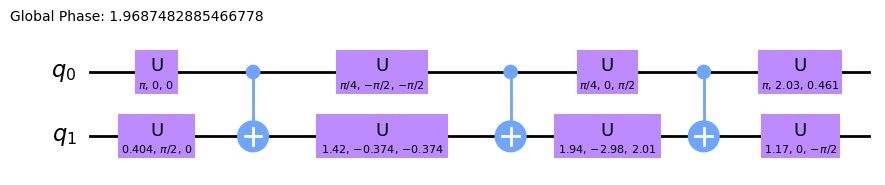

In [99]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.append(ImplicitUnitaryGate(new_op), [0, 1])
qc.decompose().draw("mpl")

In [91]:
from weylchamber import c1c2c3

c1c2c3(ImplicitUnitaryGate(new_op).to_matrix())

(0.5, 0.25, 0.25)

In [103]:
from qiskit.circuit.library import CXGate

new_op = np.kron(op, op) @ CXGate().to_matrix() @ np.kron(op, op).conj().T
ImplicitUnitaryGate(new_op)
print(np.real(new_op))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


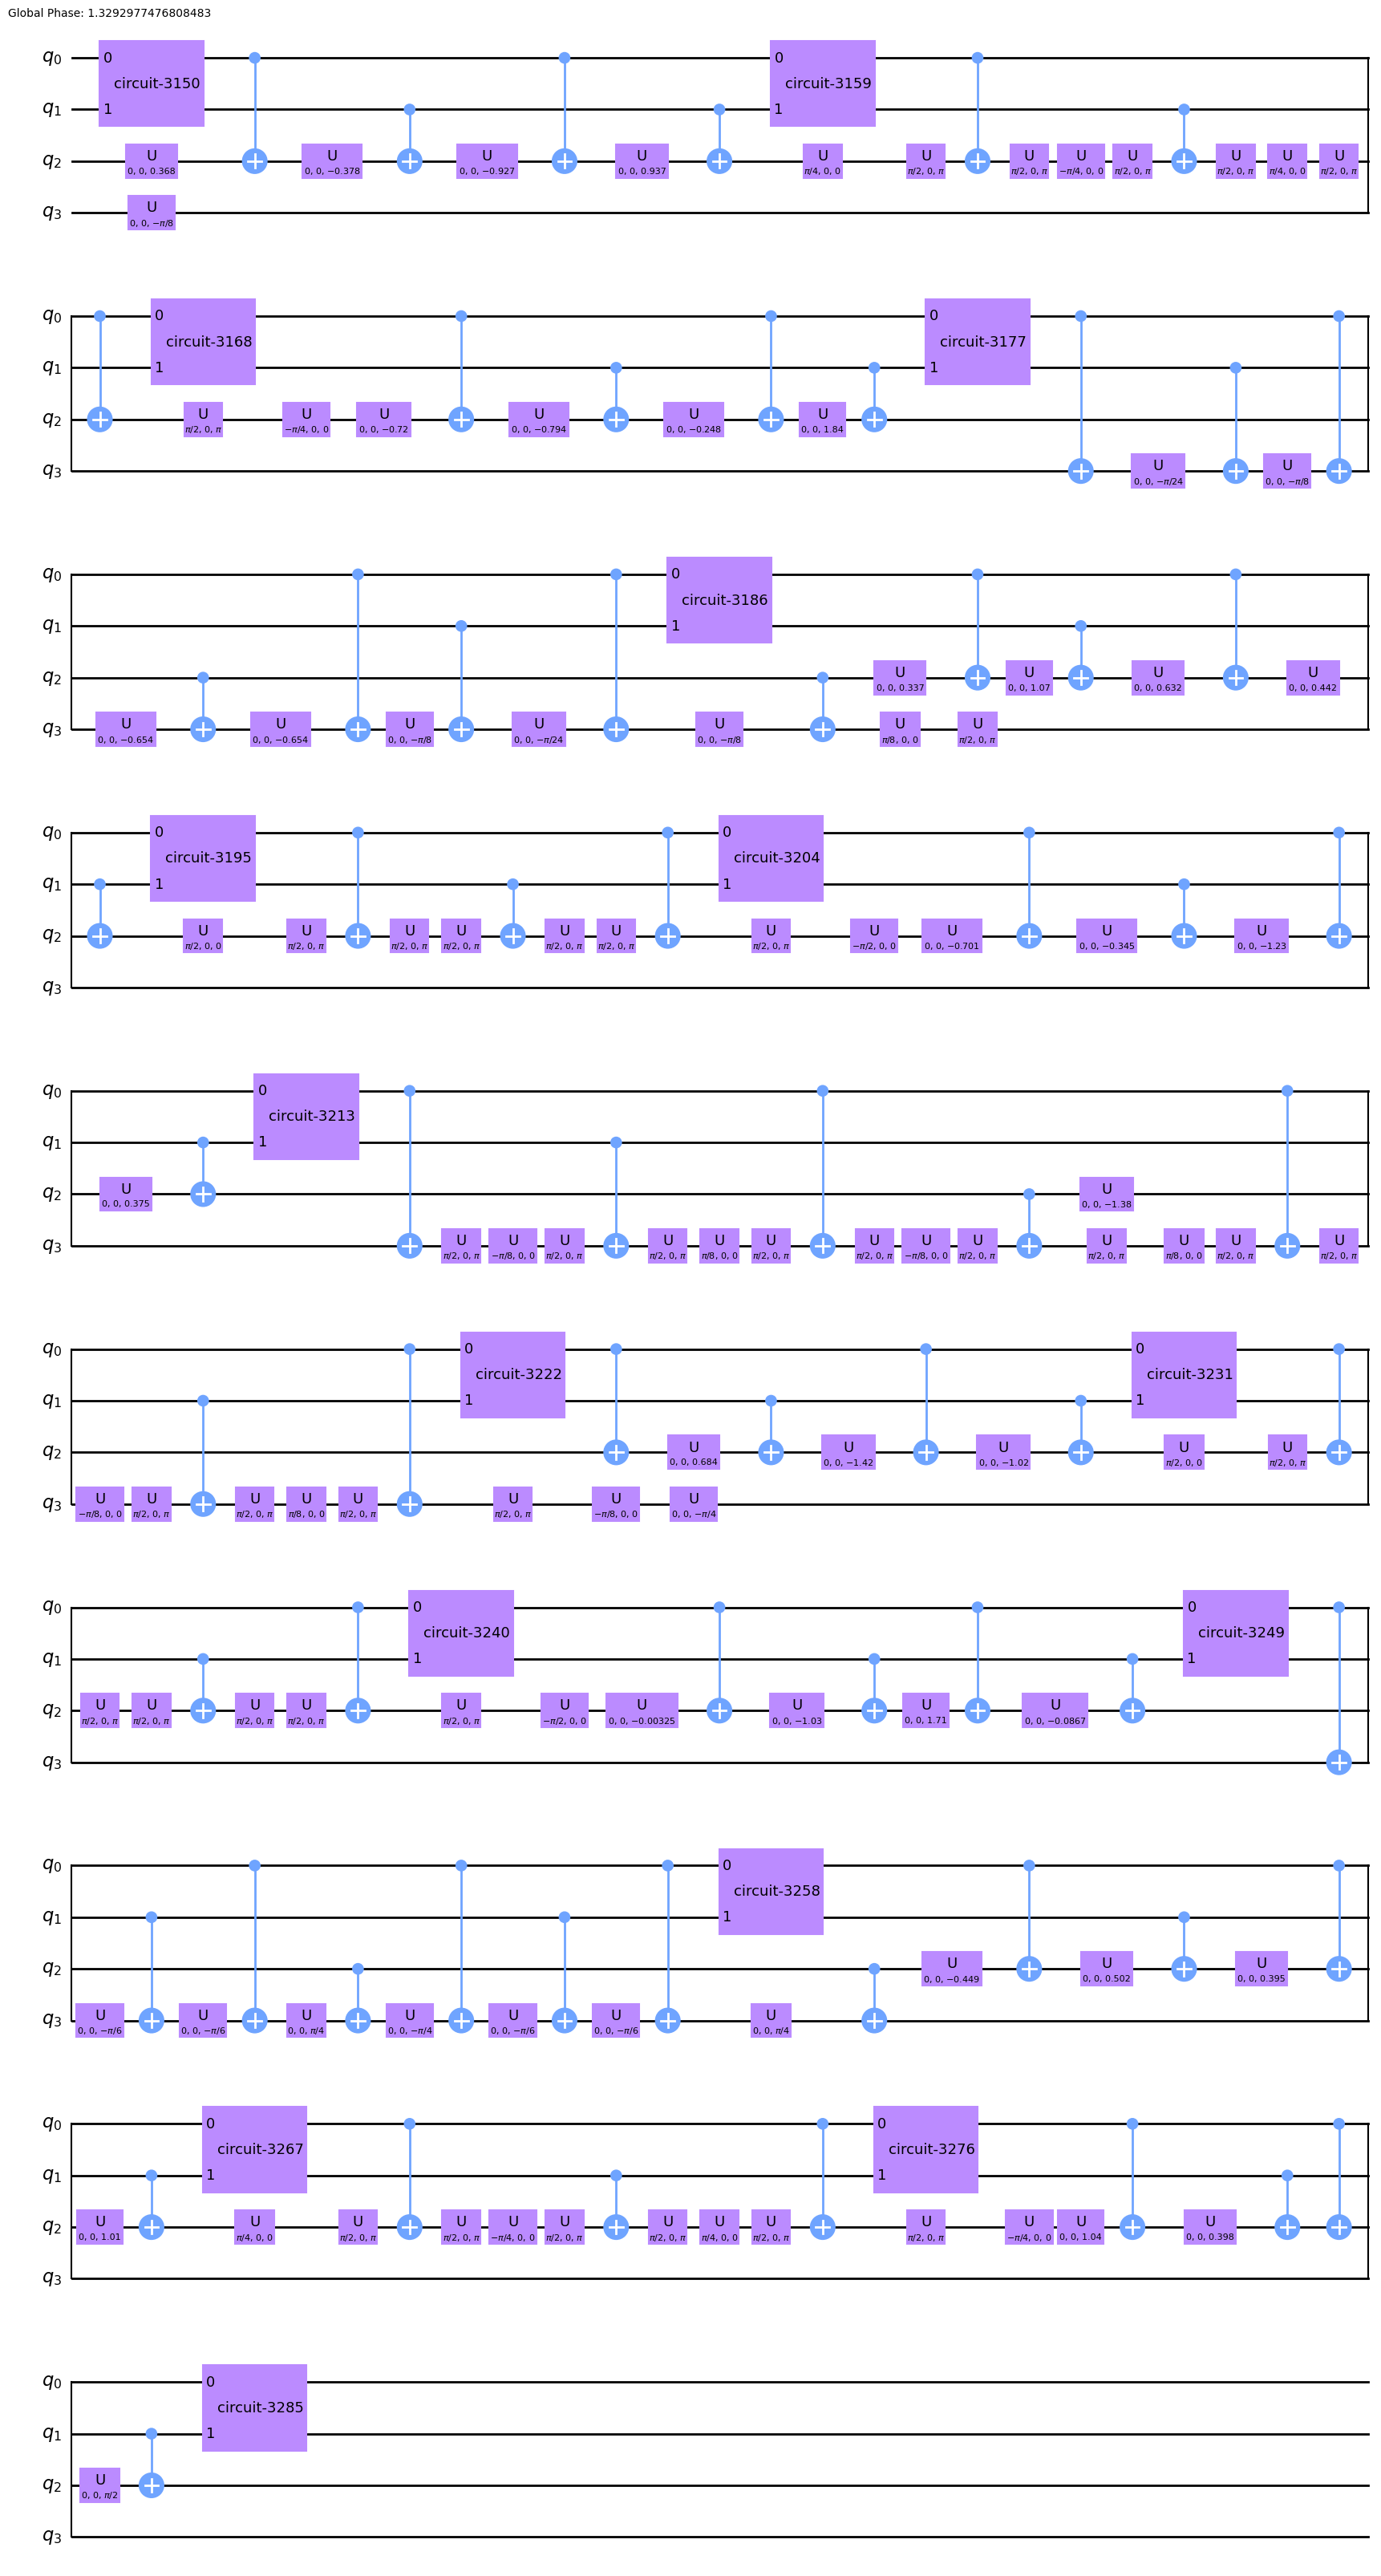

In [102]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(4)
qc.append(ImplicitUnitaryGate(new_op), [0, 1, 2, 3])
transpil
qc.decompose().draw("mpl")